# Identifying pneumonia in X-ray images
Maciej Lorens

In [1]:
import os
from pathlib import Path
import glob

import numpy as np
import pandas as pd

# PyTorch
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import  models, transforms
import pytorch_lightning as pl

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Image processing
from PIL import Image
from skimage.io import imread
import cv2

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sn
sn.set_theme(style="darkgrid")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
# Plot the loss curve based on the provided folder or the latest folder from lightning logs
def plot_loss_curve(fpath=None):
    if fpath == None:
        latest_file = os.path.join(max([os.path.join("/home/maciej/Uni/Studia II stopień/II rok/Machine Learning 2/GRU-ML-presentation/lightning_logs", f) 
                                        for f in os.listdir("lightning_logs")], 
                                        key=os.path.getctime), "metrics.csv")
    else:
        latest_file = os.path.join(fpath, "metrics.csv")
    loss_data = pd.read_csv(latest_file)
    loss_data['val_loss'] = loss_data.val_loss.shift(1)
    loss_data = loss_data[["epoch", "train_loss", "val_loss"]].dropna()
    loss_data['epoch'] = loss_data.epoch

    plt.figure(figsize=(10,5))
    plt.plot(loss_data['epoch'], loss_data['train_loss'], label="Training loss")
    plt.plot(loss_data['epoch'], loss_data['val_loss'], label = "Validation loss")
    plt.title("Loss curve", fontsize=18)
    plt.xlabel("Epoch", fontsize=16)
    plt.ylabel("Loss metric", fontsize=16)
    plt.xticks(loss_data['epoch'])
    plt.legend(loc="upper right", fontsize=16)
    plt.tight_layout()
    plt.show()

In [3]:
# Path to the images of X-rays
data_dir = Path("chest_xray")

# Path to the train directory
train_dir = data_dir / "train"

# Path to test directory
test_dir = data_dir / "test"

In [4]:
def get_image_df(img_dir):
    # Paths to normal and pneumonia xrays
    normal_dir = img_dir / "NORMAL"
    pneumonia_dir = img_dir / "PNEUMONIA"

    # List of all the images
    normal_cases = normal_dir.glob("*.jpeg")
    pneumonia_cases = pneumonia_dir.glob("*.jpeg")

    data = []

    for img in normal_cases:
        data.append((img, 0))

    for img in pneumonia_cases:
        data.append((img, 1))

    data = pd.DataFrame(data, columns=["Image_dir", "Label"])
    data = data.sample(frac=1).reset_index(drop=True)

    return data

In [5]:
train_data = get_image_df(train_dir)
test_data = get_image_df(test_dir)

In [6]:
train_data.head()

,Image_dir,Label
0,chest_xray/train/NORMAL/NORMAL2-IM-0602-0001.jpeg,0
1,chest_xray/train/PNEUMONIA/person1449_bacteria...,1
2,chest_xray/train/NORMAL/NORMAL2-IM-0547-0001.jpeg,0
3,chest_xray/train/PNEUMONIA/person1214_virus_20...,1
4,chest_xray/train/NORMAL/IM-0560-0001.jpeg,0


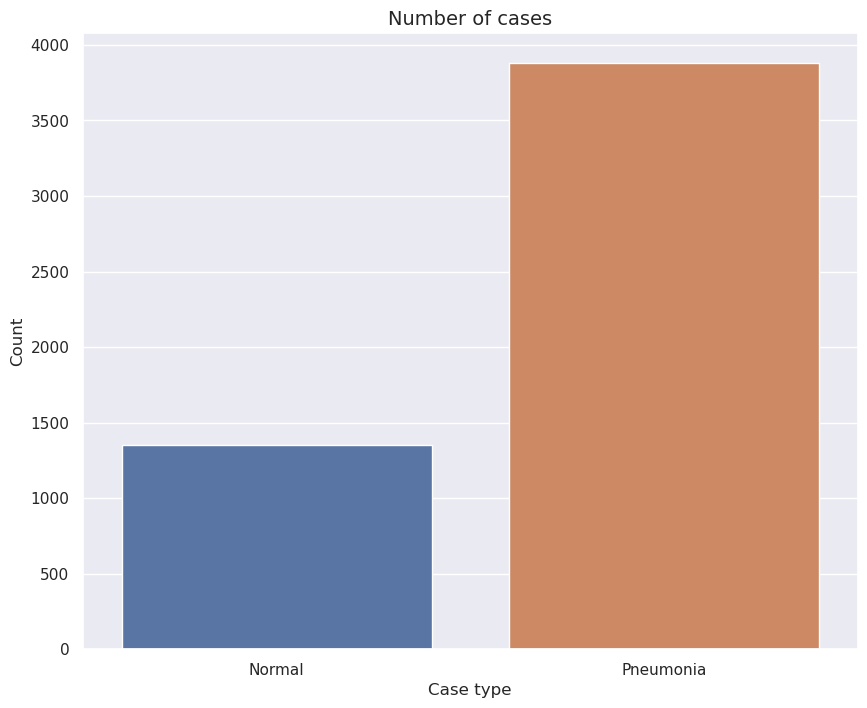

In [7]:
# Get the counts for each class
cases_count = train_data['Label'].value_counts()

# Plot the results 
plt.figure(figsize=(10, 8))
sn.barplot(x=cases_count.index, y= cases_count.values)
plt.title('Number of cases', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(cases_count.index)), ['Normal', 'Pneumonia'])
plt.show()

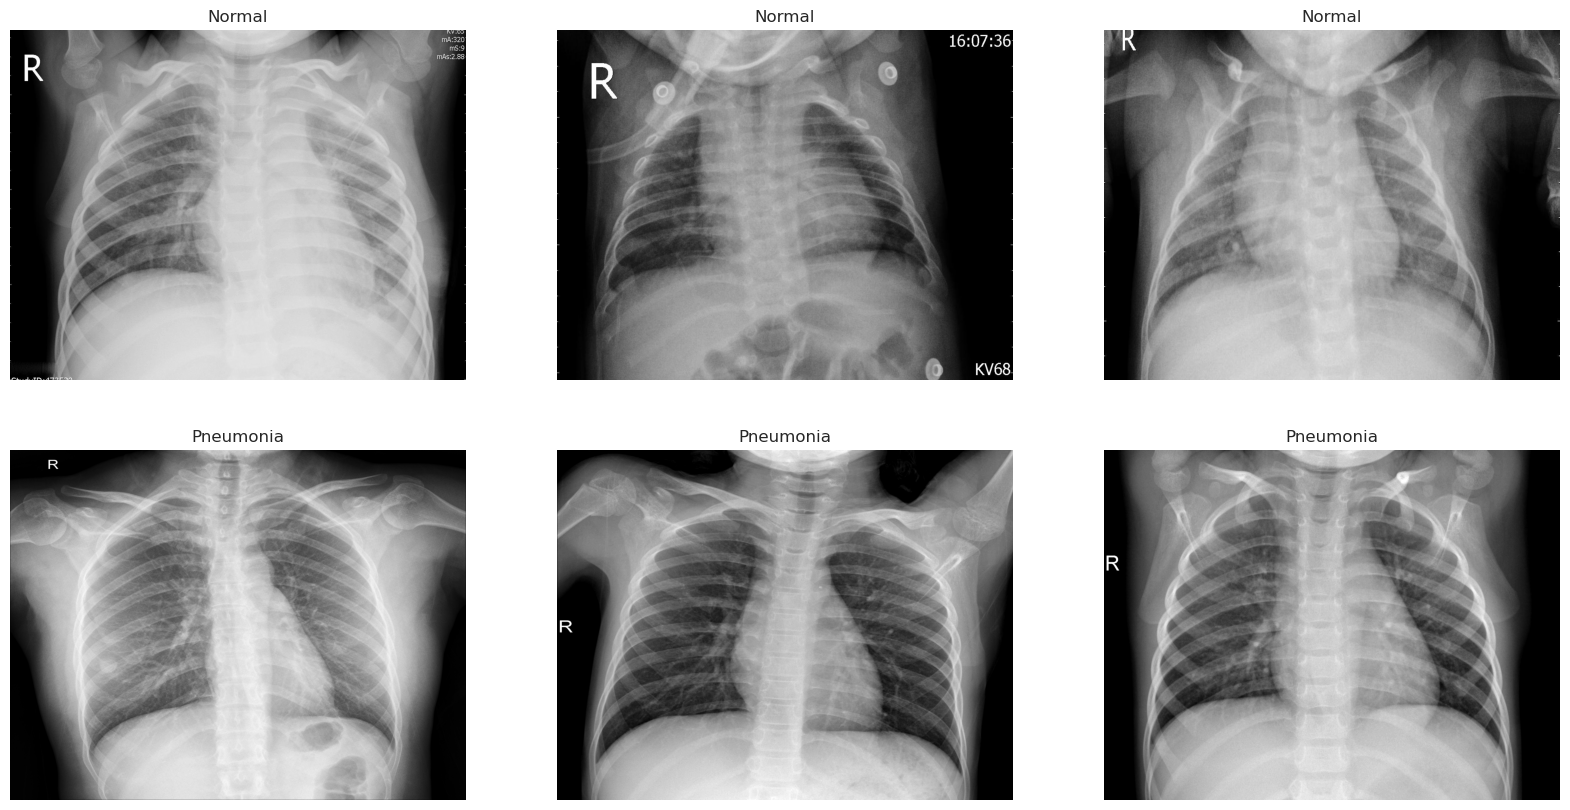

In [8]:
# Get few samples for both the classes
pneumonia_samples = (train_data[train_data['Label']==1]['Image_dir'].iloc[:3]).tolist()
normal_samples = (train_data[train_data['Label']==0]['Image_dir'].iloc[:3]).tolist()

# Concat the data in a single list
samples = pneumonia_samples + normal_samples

# Plot the data 
f, ax = plt.subplots(2, 3, figsize=(20, 10))
for i in range(6):
    img = imread(samples[i])
    ax[i//3, i%3].imshow(img, cmap='gray')
    if i<3:
        ax[i//3, i%3].set_title("Normal")
    else:
        ax[i//3, i%3].set_title("Pneumonia")
    ax[i//3, i%3].axis('off')
    ax[i//3, i%3].set_aspect('auto')
plt.show()

In [9]:
# Splitting train data into train and validation set
train_data, val_data = train_test_split(train_data, test_size=0.2, shuffle=True, stratify=train_data["Label"])
train_data, val_data = train_data.reset_index(drop=True), val_data.reset_index(drop=True)

In [10]:
print(f"Pneumonia cases in the trainining set: {train_data['Label'].value_counts()[1]}, Normal cases in the trainining set: {train_data['Label'].value_counts()[0]}")
print(f"Pneumonia cases in the validation set: {val_data['Label'].value_counts()[1]}, Normal cases in the validation set: {val_data['Label'].value_counts()[0]}")

Pneumonia cases in the trainining set: 3106, Normal cases in the trainining set: 1079
Pneumonia cases in the validation set: 777, Normal cases in the validation set: 270


In [11]:
class ImageDataset(Dataset):
    def __init__(self, data, transform, device=device):
        self.data = data
        self.transform = transform
        self.device = device
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        image_dir = self.data.Image_dir[index]
        image = Image.open(image_dir)
        label = self.data.Label[index]
        image = self.transform(image)
        # If image is greyscale then dstack
        if image.shape[0] == 1:
            image = torch.cat((image, image, image), dim=0)

        return (image, torch.tensor(label).to(torch.int64).to(self.device))

In [12]:
class PneumoniaDataLoader(pl.LightningDataModule):
    def __init__(self, train_data, val_data, test_data, random_state, batch_size, num_workers, device):
        super().__init__()
        self.train_data = train_data
        self.val_data = val_data
        self.test_data = test_data
        self.random_sate = random_state
        self.batch_size = batch_size
        self.num_workers = num_workers

    def setup(self, stage):
        data_transforms = transforms.Compose([
            transforms.Resize((150,150)),
            transforms.RandomRotation(30),
            transforms.RandomHorizontalFlip(p=0.4),
            transforms.ToTensor()
        ])

        # Create three instances of the custom dataset class
        self.image_train = ImageDataset(self.train_data, transform=data_transforms)
        self.image_val = ImageDataset(self.val_data, transform=data_transforms)
        self.image_test = ImageDataset(self.test_data, transform=data_transforms)

    def train_dataloader(self):
        # Return the dataloader of train data
        return DataLoader(self.image_train
                          , shuffle=True
                          , batch_size=self.batch_size
                          , drop_last=False
                          , num_workers=self.num_workers
                          )

    def val_dataloader(self):
        # Return the dataloader of validation data
        return DataLoader(self.image_val
                          , shuffle=False
                          , batch_size=self.batch_size
                          , drop_last=False
                          , num_workers=self.num_workers
                          )

    def test_dataloader(self):
        # Return the dataloader of test data
        return DataLoader(self.image_test
                          , shuffle=False
                          , batch_size=self.batch_size
                          , drop_last=False
                          , num_workers=self.num_workers
                          )

In [18]:
# Benchmark model class
class BenchmarkCNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(18496, 120) # 16 * 5 * 5
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)
        self.softmax = nn.Softmax(dim=1)
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(self.dropout(F.relu(self.conv2(x))))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.softmax(self.fc3(x))
        return x
    

# Transfer learning model with VGG16 for the stacking ensemble
class VGG16Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.vgg16 = models.vgg16_bn(weights=torchvision.models.VGG11_BN_Weights.DEFAULT)
        for param in self.vgg16.features.parameters():
            param.require_grad = False
        num_features = self.vgg16.classifier[6].in_features
        features = list(self.vgg16.classifier.children())[:-1]
        self.fn = nn.Linear(num_features, 2)
        self.vgg16.classifier = nn.Sequential(*features)
        self.dropout = nn.Dropout(p=0.2)
    
    def forward(self, x):
        x = self.vgg16(x)
        x = self.fn(self.dropout(x))

        return x


# Transfer learning model with DenseNet169 for the stacking ensemble
class DenseNetModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.densenet = models.densenet169(weights=torchvision.models.DenseNet169_Weights.DEFAULT)
        for param in self.densenet.features.parameters():
            param.require_grad = False
        num_features = self.densenet.classifier.in_features
        self.densenet.classifier = nn.Sequential(nn.Dropout(p=0.2), nn.Linear(num_features, 2))
    
    def forward(self, x):
        x = self.densenet(x)

        return x
    

# Meta Model for combining outputs of two other models
class MetaModel(nn.Module):
    def __init__(self, modelA, modelB):
        super().__init__()
        self.modelA = modelA
        self.modelB = modelB
        self.fn = nn.Linear(2*2, 2)
    
    def forward(self, x):
        x1 = self.modelA(x)
        x2 = self.modelB(x)
        x = self.fn(torch.cat((x1, x2), dim=1))

        return x

In [19]:
# Pneumonia classification model created with lightning
class PneumoniaModel(pl.LightningModule):
    def __init__(self, model, lr=0.001):
        super().__init__()
        # Model of choice
        self.model = model
        # Learning rate
        self.lr = lr

    def training_step(self, batch, batch_idx):
        X, y = batch
        y_pred = self.model(X)
        train_loss = F.cross_entropy(y_pred, y)
        self.log("train_loss", train_loss, prog_bar=True, on_step=False, on_epoch=True, sync_dist=True)
        return train_loss
    
    def validation_step(self, batch, batch_idx):
        X, y = batch
        y_pred = self.model(X)
        val_loss = F.cross_entropy(y_pred, y)
        self.log("val_loss", val_loss, prog_bar=True, on_step=False, on_epoch=True, sync_dist=True)

    def test_step(self, batch, batch_idx):
        X, y = batch
        y_pred = self.model(X)
        test_loss = F.cross_entropy(y_pred, y)
        self.log("test_loss", test_loss, prog_bar=True, on_step=False, on_epoch=True, sync_dist=True)
    
    def predict_step(self, batch, batch_id):
        X, y = batch
        y_pred = self.model(X)

        return y_pred

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer

In [21]:
pneumonia_loader = PneumoniaDataLoader(train_data=train_data
                                       , val_data=val_data
                                       , test_data=test_data
                                       , random_state=42
                                       , batch_size=128
                                       , num_workers=7
                                       , device=device
                                       )

### Benchmark model

In [56]:
pl.seed_everything(42, workers=True)
benchmark_model = PneumoniaModel(BenchmarkCNNModel().to(device), lr=0.001)
benchmark_trainer = pl.Trainer(max_epochs=5, check_val_every_n_epoch=1, log_every_n_steps=2)

Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [57]:
benchmark_trainer.fit(benchmark_model, datamodule=pneumonia_loader)


  | Name  | Type              | Params
--------------------------------------------
0 | model | BenchmarkCNNModel | 2.2 M 
--------------------------------------------
2.2 M     Trainable params
0         Non-trainable params
2.2 M     Total params
8.931     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


In [59]:
benchmark_trainer.test(benchmark_model, dataloaders=pneumonia_loader.test_dataloader())

Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6882617473602295
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.6882617473602295}]

### VGG16 Model

In [22]:
pl.seed_everything(42, workers=True)
vg16_model = PneumoniaModel(VGG16Model().to(device), lr=0.001)
vg16_trainer = pl.Trainer(max_epochs=5, check_val_every_n_epoch=1, log_every_n_steps=2)

Seed set to 42
/home/maciej/anaconda3/envs/learn_torch/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /home/maciej/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth
 35%|███▌      | 187M/528M [12:05<22:01, 270kB/s]


KeyboardInterrupt: 

In [17]:
vg16_trainer.fit(vg16_model, datamodule=pneumonia_loader)


  | Name  | Type       | Params
-------------------------------------
0 | model | VGG16Model | 134 M 
-------------------------------------
134 M     Trainable params
0         Non-trainable params
134 M     Total params
537.109   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

/home/maciej/anaconda3/envs/learn_torch/lib/python3.10/site-packages/pytorch_lightning/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...
